In [1]:
import torch
from transformers import BertTokenizer, BertForMaskedLM

import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

### Get pre-trained BERT Model

In [2]:
# English:
MODEL = 'bert-base-uncased'

In [3]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL)
model = BertForMaskedLM.from_pretrained(MODEL)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 1. Example of text imputation:

In [8]:
# Example sentences
sentences = ["[MASK] is a doctor", "[MASK] is a nurse", "[MASK] is an engineer"]

# Tokenize the sentences
tokenized_sentences = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in sentences]
masked_token_id = tokenizer.convert_tokens_to_ids('[MASK]')

# Tokenize the sentence
masked_indices = []
for sentence in tokenized_sentences:
    masked_indices.append([i for i, token in enumerate(sentence) if token == masked_token_id])

# Convert tokens to token IDs
input_tensors = [torch.tensor([input_ids]) for input_ids in tokenized_sentences]

In [9]:
# Predict the masked words
with torch.no_grad():
    predictions = [model(input_tensor).logits.squeeze(0) for input_tensor in input_tensors]

In [10]:
# Get the prediction of the masked tokens
def get_prediction(i, masked_indices, predictions, sentence, n=5):
    for masked_index in masked_indices[i]:
        predicted_token_probs = predictions[i][masked_index]
        top_n_predictions = torch.topk(predicted_token_probs, n)
        # Convert the token ids to actual words
        top_prediction_words = [tokenizer.decode(token_id.item()) for token_id in top_n_predictions.indices]

        # Plot the top n predictions
        plt.bar(range(n), top_n_predictions.values.tolist())
        plt.xlabel(f'Top {n} Predictions')
        plt.ylabel('Probability')
        plt.title(f'Top {n} Predictions for word in index: {masked_index}')
        plt.xticks(range(n), top_prediction_words, rotation='vertical')
        plt.show()

        predicted_token_id = torch.argmax(predictions[i][masked_index]).item()
        sentence[masked_index] = predicted_token_id

    return sentence

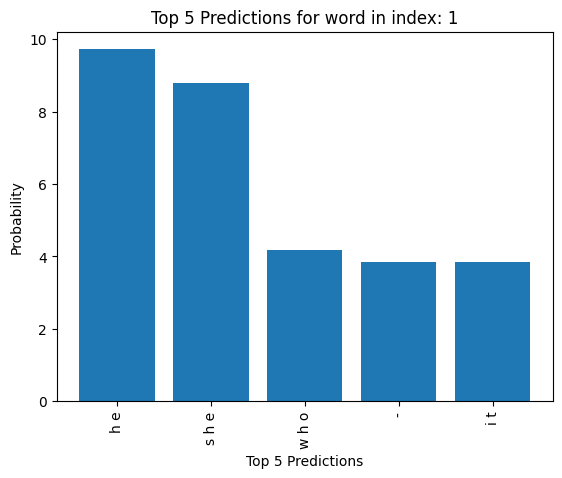

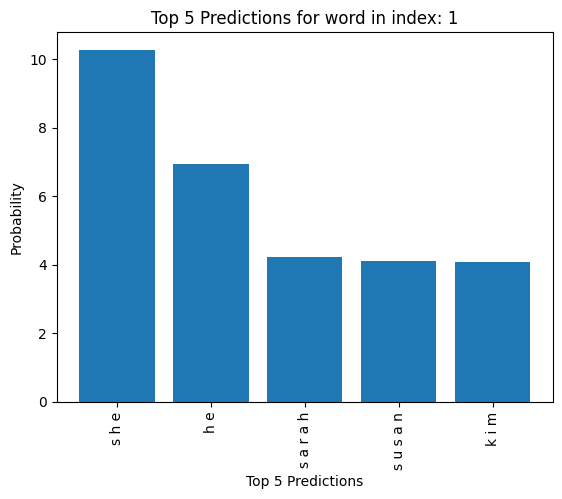

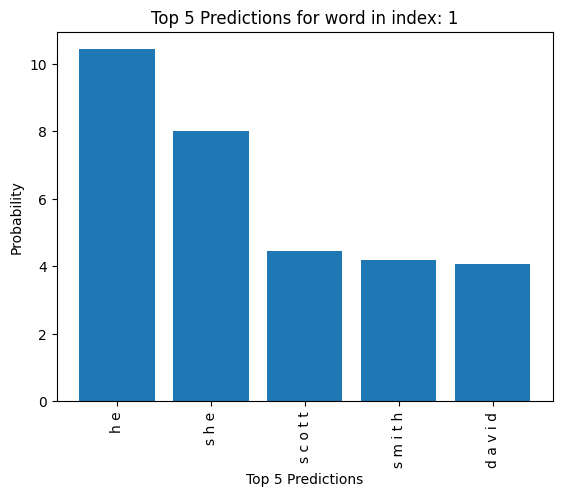

Original sentence: ['[MASK] is a doctor', '[MASK] is a nurse', '[MASK] is an engineer']
Imputed sentence: ['he is a doctor', 'she is a nurse', 'he is an engineer']


In [11]:
# Replace the masked words with the predicted words
imputed_sentences = [get_prediction(i, masked_indices, predictions, sentence) for i, sentence in enumerate(tokenized_sentences)]

# Reconstruct the imputed sentence
imputed_sentences = [tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(imputed_sentence, skip_special_tokens=True)) for imputed_sentence in imputed_sentences]

print("Original sentence:", sentences)
print("Imputed sentence:", imputed_sentences)

### 2. UI Example:

In [8]:
import gradio as gr
import plotly.graph_objects as go

def get_prediction(i, masked_indices, predictions, sentence):
    for masked_index in masked_indices[i]:
        predicted_token_id = torch.argmax(predictions[i][masked_index]).item()
        sentence[masked_index] = predicted_token_id

    return sentence

def password(password):
    return password == 'burpee'


def complete_sentence(sentences):

    sentences = sentences.split("\n")

    # Tokenize the sentences
    if isinstance(sentences, str):
        sentences = [sentences]

    # Tokenize the sentences
    tokenized_sentences = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in sentences]
    masked_token_id = tokenizer.convert_tokens_to_ids('[MASK]')

    # Tokenize the sentence
    masked_indices = []
    for sentence in tokenized_sentences:
        masked_indices.append([i for i, token in enumerate(sentence) if token == masked_token_id])

    # Convert tokens to token IDs
    input_tensors = [torch.tensor([input_ids]) for input_ids in tokenized_sentences]

    # Predict the masked words
    with torch.no_grad():
        predictions = [model(input_tensor).logits.squeeze(0) for input_tensor in input_tensors]

    # Replace the masked words with the predicted words
    imputed_sentences = [get_prediction(i, masked_indices, predictions, sentence) for i, sentence in enumerate(tokenized_sentences)]

    imputed_sentences_tekens = [[(token, '+' if token == masked_token_id else None) for token in sentence] for sentence in imputed_sentences]

    # Reconstruct the imputed sentence
    imputed_sentences = [tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(imputed_sentence, skip_special_tokens=True)) for imputed_sentence in imputed_sentences]

    return sentences, imputed_sentences

def display_imputed_sentences(sentences):
    # Get the original and imputed sentences
    original_sentences, imputed_sentences = complete_sentence(sentences)

    display_sentences = []
    for sentence, imputed_sentence in zip(original_sentences, imputed_sentences):

        sentence = sentence.split()
        imputed_sentence = imputed_sentence.split()

        for index in range(len(sentence)):
            word = sentence[index]
            imputed_word = imputed_sentence[index]
            if word == '[MASK]':
                display_sentences.append((imputed_word, '+'))
            else:
                display_sentences.append((word, None))
            display_sentences.append((' ', None))

        display_sentences.append(('\n', '-'))

    display_sentences = ''.join([word for word, _ in display_sentences])

    return display_sentences


with gr.Blocks() as demo:

    # Define the input component
    input_text = gr.Textbox(lines=3, 
                            label="Enter one sentence per line. Maked values shoud be represented as [MASK]", 
                            value="[MASK] is a doctor \n[MASK] is a nurse \n[MASK] is an engineer \n[MASK] is a teacher")


    # Define the button component
    btn = gr.Button(value="Complete the text")

    # Define the output component
    out = gr.Textbox()

    # If button is clicked, run the function
    btn.click(display_imputed_sentences, inputs=[input_text], outputs=[out])

    # load the interface:
    demo.load(display_imputed_sentences, inputs=[input_text], outputs=[out])

    # Run the interface
    demo.launch()
    #demo.launch(auth=password)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
